In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

!pip install -q condacolab
import condacolab

condacolab.install()

import condacolab

condacolab.check()
!conda install -c conda-forge openbabel

condacolab.check()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
✨🍰✨ Everything looks OK!
✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

✨🍰✨ Everything looks OK!


In [2]:
!pip install rdkit
!pip install biopython
!pip install posebusters

  Using cached posebusters-0.3.2-py3-none-any.whl.metadata (4.4 kB)
Using cached posebusters-0.3.2-py3-none-any.whl (553 kB)


Streaming output truncated to the last 5000 lines.
Pose 2: PLI = 0.000
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31/7R6J_2I7/pocket_thr05_Minimal13.pdb
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31/7R6J_2I7/pocket_thr05_Minimal13.pdb
Loading ligand file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31/7R6J_2I7/7R6J_2I7_ligands.sdf
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31/7R6J_2I7/7R6J_2I7_ligands.sdf
Pose 1: PLI = 0.000
Pose 2: PLI = 0.000
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31/7R6J_2I7/pocket_thr05_Minimal18.pdb
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31/7R6J_2I7/pocket_thr05_Minimal18.pdb
Loading ligan

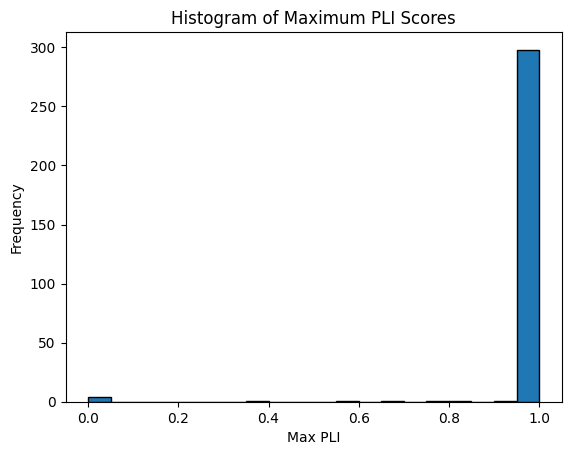

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.

    Args:
        ligand (BindingPocket): The ligand structure as a set of atomic coordinates.
        pocket (BindingPocket): The pocket structure as a set of atomic coordinates.
        cutoff_distance (float): The maximum distance (in Å) to consider an atom interacting.

    Returns:
        float: PLI score as a fraction of ligand atoms interacting with the pocket.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Generator to extract atomic coordinates from a molecular structure file.

    Args:
        file_path (str): Path to the molecular structure file (PDB or SDF).
        heavy_only (bool): If True, only include heavy atoms (atomic number > 1).

    Yields:
        np.ndarray: A NumPy array of atomic coordinates.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            yield np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            yield np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for all ligand poses and all pockets in a subfolder.

    Args:
        subdir_path (str): Path to the subfolder containing pocket and ligand files.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).

    Returns:
        float: Maximum PLI score among all poses and pockets in the subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket_thr05_Minimal" in file and file.endswith(".pdb")]
    ligand_files = [file for file in os.listdir(subdir_path) if file.endswith("_ligands.sdf")]

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}")
    if not ligand_files:
        print(f"No ligand files found in {subdir_path}")

    if not pocket_files or not ligand_files:
        return None

    max_pli = 0
    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = next(coordinates(pocket_file_path, heavy_only=False))
        pocket = BindingPocket(pocket_coords)

        for ligand_file in ligand_files:
            ligand_file_path = os.path.join(subdir_path, ligand_file)
            print(f"Loading ligand file: {ligand_file_path}")
            for pose_idx, lig_coords in enumerate(coordinates(ligand_file_path, heavy_only=True), start=1):
                ligand = BindingPocket(lig_coords)
                pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
                print(f"Pose {pose_idx}: PLI = {pli:.3f}")
                max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder.

    Args:
        main_folder (str): Path to the main folder containing subfolders.
        subfolder_list_file (str): Path to the file listing subfolder names.
        output_csv (str): Path to save the output CSV file.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).
    """
    print(f"Reading subfolder list from: {subfolder_list_file}")
    with open(subfolder_list_file, 'r') as f:
        subfolders = [line.strip() for line in f]

    results = []

    for subdir in subfolders:
        subdir_path = os.path.join(main_folder, subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31"
subfolder_list_file = "/content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt"
output_csv = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET_Ensemble_MINORITY_max_pli_results.csv"

process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0)

Reading subfolder list from: /content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt
Processing subfolder: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31/5SAK_ZRY
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31/5SAK_ZRY/pocket_thr05_Majority0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31/5SAK_ZRY/pocket_thr05_Majority0.pdb
Loading ligand file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31/5SAK_ZRY/5SAK_ZRY_ligands.sdf
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31/5SAK_ZRY/5SAK_ZRY_ligands.sdf
Pose 1: PLI = 1.000
Max PLI for subfolder /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31/5SAK_ZRY: 1.000
Processing subfolder: /content/gdrive/MyDrive/Docking_bench

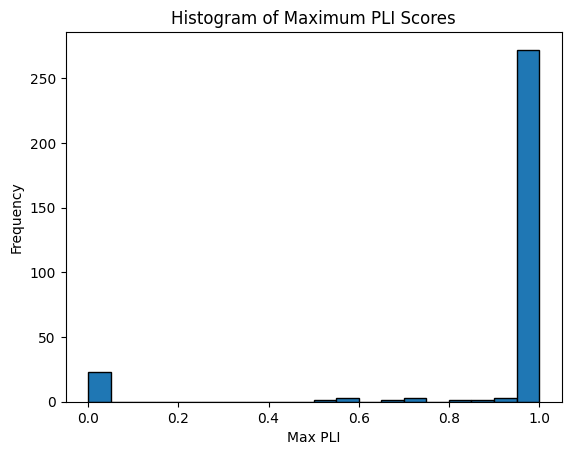

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.

    Args:
        ligand (BindingPocket): The ligand structure as a set of atomic coordinates.
        pocket (BindingPocket): The pocket structure as a set of atomic coordinates.
        cutoff_distance (float): The maximum distance (in Å) to consider an atom interacting.

    Returns:
        float: PLI score as a fraction of ligand atoms interacting with the pocket.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Generator to extract atomic coordinates from a molecular structure file.

    Args:
        file_path (str): Path to the molecular structure file (PDB or SDF).
        heavy_only (bool): If True, only include heavy atoms (atomic number > 1).

    Yields:
        np.ndarray: A NumPy array of atomic coordinates.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            yield np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            yield np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for all ligand poses and all pockets in a subfolder.

    Args:
        subdir_path (str): Path to the subfolder containing pocket and ligand files.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).

    Returns:
        float: Maximum PLI score among all poses and pockets in the subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket_thr05_Majority" in file and file.endswith(".pdb")]
    ligand_files = [file for file in os.listdir(subdir_path) if file.endswith("_ligands.sdf")]

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}")
    if not ligand_files:
        print(f"No ligand files found in {subdir_path}")

    if not pocket_files or not ligand_files:
        return None

    max_pli = 0
    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = next(coordinates(pocket_file_path, heavy_only=False))  # Include all atoms in the pocket
        pocket = BindingPocket(pocket_coords)

        for ligand_file in ligand_files:
            ligand_file_path = os.path.join(subdir_path, ligand_file)
            print(f"Loading ligand file: {ligand_file_path}")
            for pose_idx, lig_coords in enumerate(coordinates(ligand_file_path, heavy_only=True), start=1):  # Only heavy atoms in ligand
                ligand = BindingPocket(lig_coords)
                pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
                print(f"Pose {pose_idx}: PLI = {pli:.3f}")
                max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder.

    Args:
        main_folder (str): Path to the main folder containing subfolders.
        subfolder_list_file (str): Path to the file listing subfolder names.
        output_csv (str): Path to save the output CSV file.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).
    """
    print(f"Reading subfolder list from: {subfolder_list_file}")
    with open(subfolder_list_file, 'r') as f:
        subfolders = [line.strip() for line in f]

    results = []

    for subdir in subfolders:
        subdir_path = os.path.join(main_folder, subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET31"
subfolder_list_file = "/content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt"
output_csv = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET_Ensemble_Majority_max_pli_results.csv"

process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0)

Streaming output truncated to the last 5000 lines.
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET32/7LJN_GTP/7LJN_GTP_ligands.sdf
Pose 1: PLI = 0.000
Pose 2: PLI = 0.000
Pose 3: PLI = 0.000
Pose 4: PLI = 0.000
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET32/7LJN_GTP/pocket_thr05_Minimal3.pdb
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET32/7LJN_GTP/pocket_thr05_Minimal3.pdb
Loading ligand file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET32/7LJN_GTP/7LJN_GTP_ligands.sdf
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET32/7LJN_GTP/7LJN_GTP_ligands.sdf
Pose 1: PLI = 0.000
Pose 2: PLI = 0.000
Pose 3: PLI = 0.000
Pose 4: PLI = 0.000
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/

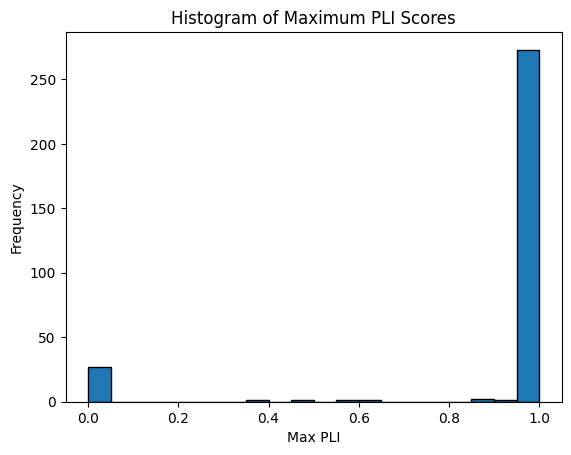

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.

    Args:
        ligand (BindingPocket): The ligand structure as a set of atomic coordinates.
        pocket (BindingPocket): The pocket structure as a set of atomic coordinates.
        cutoff_distance (float): The maximum distance (in Å) to consider an atom interacting.

    Returns:
        float: PLI score as a fraction of ligand atoms interacting with the pocket.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Generator to extract atomic coordinates from a molecular structure file.

    Args:
        file_path (str): Path to the molecular structure file (PDB or SDF).
        heavy_only (bool): If True, only include heavy atoms (atomic number > 1).

    Yields:
        np.ndarray: A NumPy array of atomic coordinates.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            yield np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            yield np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for all ligand poses and all pockets in a subfolder.

    Args:
        subdir_path (str): Path to the subfolder containing pocket and ligand files.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).

    Returns:
        float: Maximum PLI score among all poses and pockets in the subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket_thr05_Minimal" in file and file.endswith(".pdb")]
    ligand_files = [file for file in os.listdir(subdir_path) if file.endswith("_ligands.sdf")]

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}")
    if not ligand_files:
        print(f"No ligand files found in {subdir_path}")

    if not pocket_files or not ligand_files:
        return None

    max_pli = 0
    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = next(coordinates(pocket_file_path, heavy_only=False))
        pocket = BindingPocket(pocket_coords)

        for ligand_file in ligand_files:
            ligand_file_path = os.path.join(subdir_path, ligand_file)
            print(f"Loading ligand file: {ligand_file_path}")
            for pose_idx, lig_coords in enumerate(coordinates(ligand_file_path, heavy_only=True), start=1):
                ligand = BindingPocket(lig_coords)
                pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
                print(f"Pose {pose_idx}: PLI = {pli:.3f}")
                max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder.

    Args:
        main_folder (str): Path to the main folder containing subfolders.
        subfolder_list_file (str): Path to the file listing subfolder names.
        output_csv (str): Path to save the output CSV file.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).
    """
    print(f"Reading subfolder list from: {subfolder_list_file}")
    with open(subfolder_list_file, 'r') as f:
        subfolders = [line.strip() for line in f]

    results = []

    for subdir in subfolders:
        subdir_path = os.path.join(main_folder, subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET32"
subfolder_list_file = "/content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt"
output_csv = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET32_max_pli_results.csv"

process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0)


Reading subfolder list from: /content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt
Processing subfolder: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET33/5SAK_ZRY
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET33/5SAK_ZRY/pocket_thr05_Minimal0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET33/5SAK_ZRY/pocket_thr05_Minimal0.pdb
Loading ligand file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET33/5SAK_ZRY/5SAK_ZRY_ligands.sdf
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET33/5SAK_ZRY/5SAK_ZRY_ligands.sdf
Pose 1: PLI = 1.000
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET33/5SAK_ZRY/pocket_thr05_Minimal1.pdb
Reading coordinates from file: /content/gdr

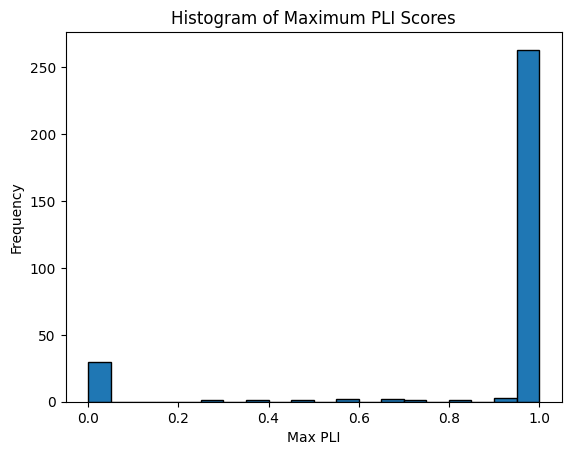

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.

    Args:
        ligand (BindingPocket): The ligand structure as a set of atomic coordinates.
        pocket (BindingPocket): The pocket structure as a set of atomic coordinates.
        cutoff_distance (float): The maximum distance (in Å) to consider an atom interacting.

    Returns:
        float: PLI score as a fraction of ligand atoms interacting with the pocket.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Generator to extract atomic coordinates from a molecular structure file.

    Args:
        file_path (str): Path to the molecular structure file (PDB or SDF).
        heavy_only (bool): If True, only include heavy atoms (atomic number > 1).

    Yields:
        np.ndarray: A NumPy array of atomic coordinates.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            yield np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            yield np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for all ligand poses and all pockets in a subfolder.

    Args:
        subdir_path (str): Path to the subfolder containing pocket and ligand files.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).

    Returns:
        float: Maximum PLI score among all poses and pockets in the subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket_thr05_Minimal" in file and file.endswith(".pdb")]
    ligand_files = [file for file in os.listdir(subdir_path) if file.endswith("_ligands.sdf")]

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}")
    if not ligand_files:
        print(f"No ligand files found in {subdir_path}")

    if not pocket_files or not ligand_files:
        return None

    max_pli = 0
    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = next(coordinates(pocket_file_path, heavy_only=False))
        pocket = BindingPocket(pocket_coords)

        for ligand_file in ligand_files:
            ligand_file_path = os.path.join(subdir_path, ligand_file)
            print(f"Loading ligand file: {ligand_file_path}")
            for pose_idx, lig_coords in enumerate(coordinates(ligand_file_path, heavy_only=True), start=1):
                ligand = BindingPocket(lig_coords)
                pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
                print(f"Pose {pose_idx}: PLI = {pli:.3f}")
                max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder.

    Args:
        main_folder (str): Path to the main folder containing subfolders.
        subfolder_list_file (str): Path to the file listing subfolder names.
        output_csv (str): Path to save the output CSV file.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).
    """
    print(f"Reading subfolder list from: {subfolder_list_file}")
    with open(subfolder_list_file, 'r') as f:
        subfolders = [line.strip() for line in f]

    results = []

    for subdir in subfolders:
        subdir_path = os.path.join(main_folder, subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET33"
subfolder_list_file = "/content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt"
output_csv = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET33_max_pli_results.csv"

process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0)


Streaming output truncated to the last 5000 lines.
Pose 4: PLI = 0.000
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET35/7K0V_VQP/pocket_thr05_Minimal9.pdb
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET35/7K0V_VQP/pocket_thr05_Minimal9.pdb
Loading ligand file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET35/7K0V_VQP/7K0V_VQP_ligands.sdf
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET35/7K0V_VQP/7K0V_VQP_ligands.sdf
Pose 1: PLI = 0.000
Pose 2: PLI = 0.000
Pose 3: PLI = 0.000
Pose 4: PLI = 0.000
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET35/7K0V_VQP/pocket_thr05_Minimal10.pdb
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET35/7K0V_VQP/po

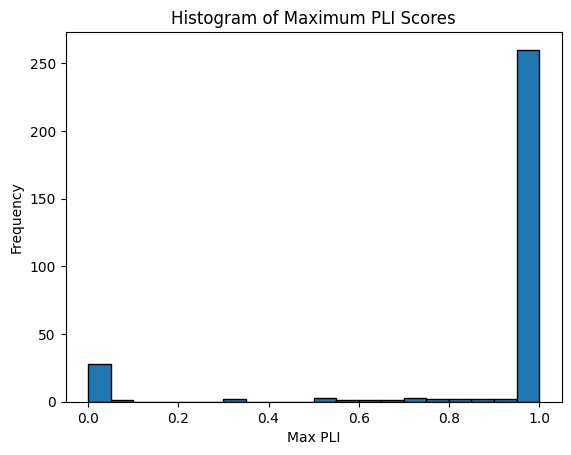

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.

    Args:
        ligand (BindingPocket): The ligand structure as a set of atomic coordinates.
        pocket (BindingPocket): The pocket structure as a set of atomic coordinates.
        cutoff_distance (float): The maximum distance (in Å) to consider an atom interacting.

    Returns:
        float: PLI score as a fraction of ligand atoms interacting with the pocket.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Generator to extract atomic coordinates from a molecular structure file.

    Args:
        file_path (str): Path to the molecular structure file (PDB or SDF).
        heavy_only (bool): If True, only include heavy atoms (atomic number > 1).

    Yields:
        np.ndarray: A NumPy array of atomic coordinates.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            yield np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            yield np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for all ligand poses and all pockets in a subfolder.

    Args:
        subdir_path (str): Path to the subfolder containing pocket and ligand files.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).

    Returns:
        float: Maximum PLI score among all poses and pockets in the subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket_thr05_Minimal" in file and file.endswith(".pdb")]
    ligand_files = [file for file in os.listdir(subdir_path) if file.endswith("_ligands.sdf")]

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}")
    if not ligand_files:
        print(f"No ligand files found in {subdir_path}")

    if not pocket_files or not ligand_files:
        return None

    max_pli = 0
    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = next(coordinates(pocket_file_path, heavy_only=False))
        pocket = BindingPocket(pocket_coords)

        for ligand_file in ligand_files:
            ligand_file_path = os.path.join(subdir_path, ligand_file)
            print(f"Loading ligand file: {ligand_file_path}")
            for pose_idx, lig_coords in enumerate(coordinates(ligand_file_path, heavy_only=True), start=1):
                ligand = BindingPocket(lig_coords)
                pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
                print(f"Pose {pose_idx}: PLI = {pli:.3f}")
                max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder.

    Args:
        main_folder (str): Path to the main folder containing subfolders.
        subfolder_list_file (str): Path to the file listing subfolder names.
        output_csv (str): Path to save the output CSV file.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).
    """

    print(f"Reading subfolder list from: {subfolder_list_file}")
    with open(subfolder_list_file, 'r') as f:
        subfolders = [line.strip() for line in f]

    results = []

    for subdir in subfolders:
        subdir_path = os.path.join(main_folder, subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET35"
subfolder_list_file = "/content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt"
output_csv = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET35_max_pli_results.csv"

process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0)


Reading subfolder list from: /content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt
Processing subfolder: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET36/5SAK_ZRY
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET36/5SAK_ZRY/pocket_thr05_Minimal0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET36/5SAK_ZRY/pocket_thr05_Minimal0.pdb
Loading ligand file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET36/5SAK_ZRY/5SAK_ZRY_ligands.sdf
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET36/5SAK_ZRY/5SAK_ZRY_ligands.sdf
Pose 1: PLI = 1.000
Max PLI for subfolder /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET36/5SAK_ZRY: 1.000
Processing subfolder: /content/gdrive/MyDrive/Docking_benchma

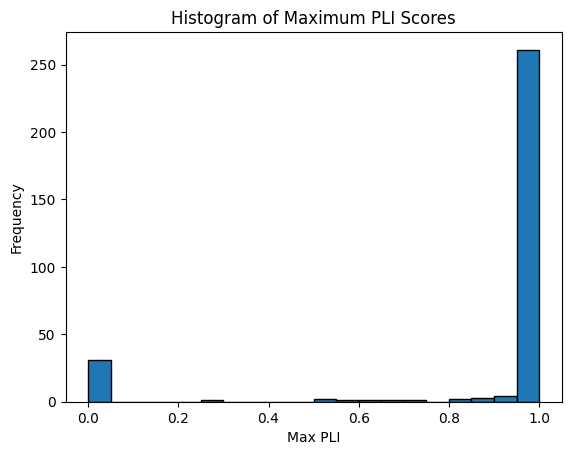

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.

    Args:
        ligand (BindingPocket): The ligand structure as a set of atomic coordinates.
        pocket (BindingPocket): The pocket structure as a set of atomic coordinates.
        cutoff_distance (float): The maximum distance (in Å) to consider an atom interacting.

    Returns:
        float: PLI score as a fraction of ligand atoms interacting with the pocket.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Generator to extract atomic coordinates from a molecular structure file.

    Args:
        file_path (str): Path to the molecular structure file (PDB or SDF).
        heavy_only (bool): If True, only include heavy atoms (atomic number > 1).

    Yields:
        np.ndarray: A NumPy array of atomic coordinates.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            yield np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            yield np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for all ligand poses and all pockets in a subfolder.

    Args:
        subdir_path (str): Path to the subfolder containing pocket and ligand files.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).

    Returns:
        float: Maximum PLI score among all poses and pockets in the subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket_thr05_Minimal" in file and file.endswith(".pdb")]
    ligand_files = [file for file in os.listdir(subdir_path) if file.endswith("_ligands.sdf")]

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}")
    if not ligand_files:
        print(f"No ligand files found in {subdir_path}")

    if not pocket_files or not ligand_files:
        return None

    max_pli = 0
    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = next(coordinates(pocket_file_path, heavy_only=False))
        pocket = BindingPocket(pocket_coords)

        for ligand_file in ligand_files:
            ligand_file_path = os.path.join(subdir_path, ligand_file)
            print(f"Loading ligand file: {ligand_file_path}")
            for pose_idx, lig_coords in enumerate(coordinates(ligand_file_path, heavy_only=True), start=1):
                ligand = BindingPocket(lig_coords)
                pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
                print(f"Pose {pose_idx}: PLI = {pli:.3f}")
                max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder.

    Args:
        main_folder (str): Path to the main folder containing subfolders.
        subfolder_list_file (str): Path to the file listing subfolder names.
        output_csv (str): Path to save the output CSV file.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).
    """
    print(f"Reading subfolder list from: {subfolder_list_file}")
    with open(subfolder_list_file, 'r') as f:
        subfolders = [line.strip() for line in f]

    results = []

    for subdir in subfolders:
        subdir_path = os.path.join(main_folder, subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET36"
subfolder_list_file = "/content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt"
output_csv = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET36_max_pli_results.csv"

process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0)


Streaming output truncated to the last 5000 lines.
Pose 1: PLI = 0.000
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET41/7Q5I_I0F/pocket_thr05_Minimal15.pdb
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET41/7Q5I_I0F/pocket_thr05_Minimal15.pdb
Loading ligand file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET41/7Q5I_I0F/7Q5I_I0F_ligands.sdf
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET41/7Q5I_I0F/7Q5I_I0F_ligands.sdf
Pose 1: PLI = 1.000
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET41/7Q5I_I0F/pocket_thr05_Minimal16.pdb
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET41/7Q5I_I0F/pocket_thr05_Minimal16.pdb
Loading ligand file: /content/gdr

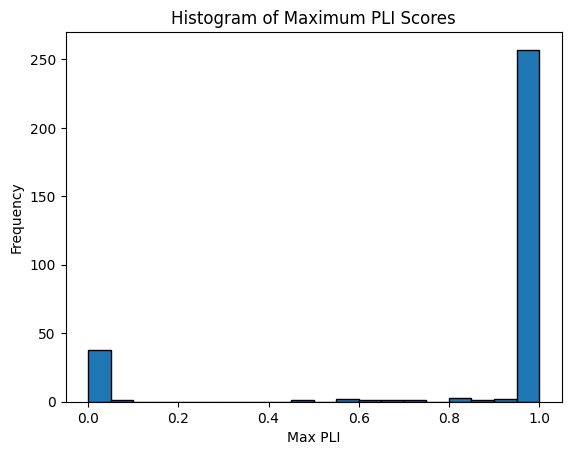

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.

    Args:
        ligand (BindingPocket): The ligand structure as a set of atomic coordinates.
        pocket (BindingPocket): The pocket structure as a set of atomic coordinates.
        cutoff_distance (float): The maximum distance (in Å) to consider an atom interacting.

    Returns:
        float: PLI score as a fraction of ligand atoms interacting with the pocket.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Generator to extract atomic coordinates from a molecular structure file.

    Args:
        file_path (str): Path to the molecular structure file (PDB or SDF).
        heavy_only (bool): If True, only include heavy atoms (atomic number > 1).

    Yields:
        np.ndarray: A NumPy array of atomic coordinates.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            yield np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            yield np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for all ligand poses and all pockets in a subfolder.

    Args:
        subdir_path (str): Path to the subfolder containing pocket and ligand files.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).

    Returns:
        float: Maximum PLI score among all poses and pockets in the subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket_thr05_Minimal" in file and file.endswith(".pdb")]
    ligand_files = [file for file in os.listdir(subdir_path) if file.endswith("_ligands.sdf")]

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}")
    if not ligand_files:
        print(f"No ligand files found in {subdir_path}")

    if not pocket_files or not ligand_files:
        return None

    max_pli = 0
    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = next(coordinates(pocket_file_path, heavy_only=False))
        pocket = BindingPocket(pocket_coords)

        for ligand_file in ligand_files:
            ligand_file_path = os.path.join(subdir_path, ligand_file)
            print(f"Loading ligand file: {ligand_file_path}")
            for pose_idx, lig_coords in enumerate(coordinates(ligand_file_path, heavy_only=True), start=1):
                ligand = BindingPocket(lig_coords)
                pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
                print(f"Pose {pose_idx}: PLI = {pli:.3f}")
                max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder.

    Args:
        main_folder (str): Path to the main folder containing subfolders.
        subfolder_list_file (str): Path to the file listing subfolder names.
        output_csv (str): Path to save the output CSV file.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).
    """

    print(f"Reading subfolder list from: {subfolder_list_file}")
    with open(subfolder_list_file, 'r') as f:
        subfolders = [line.strip() for line in f]

    results = []

    for subdir in subfolders:
        subdir_path = os.path.join(main_folder, subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/posebusters_benchmark_set_SET41"
subfolder_list_file = "/content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt"
output_csv = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET41_max_pli_results.csv"

process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0)


Reading subfolder list from: /content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt
Processing subfolder: /content/gdrive/MyDrive/Docking_benchmarks/Kalasanty_comparison/posebusters_benchmark_set/5SAK_ZRY
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/Kalasanty_comparison/posebusters_benchmark_set/5SAK_ZRY/pocket_thr05_Minimal0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/Kalasanty_comparison/posebusters_benchmark_set/5SAK_ZRY/pocket_thr05_Minimal0.pdb
Loading ligand file: /content/gdrive/MyDrive/Docking_benchmarks/Kalasanty_comparison/posebusters_benchmark_set/5SAK_ZRY/5SAK_ZRY_ligands.sdf
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/Kalasanty_comparison/posebusters_benchmark_set/5SAK_ZRY/5SAK_ZRY_ligands.sdf
Pose 1: PLI = 1.000
Max PLI for subfolder /content/gdrive/MyDrive/Docking_benchmarks/Kalasanty_comparison/posebusters_benchmark_set/5SAK_ZRY: 1.000
Processing subfolder: /content/gdrive

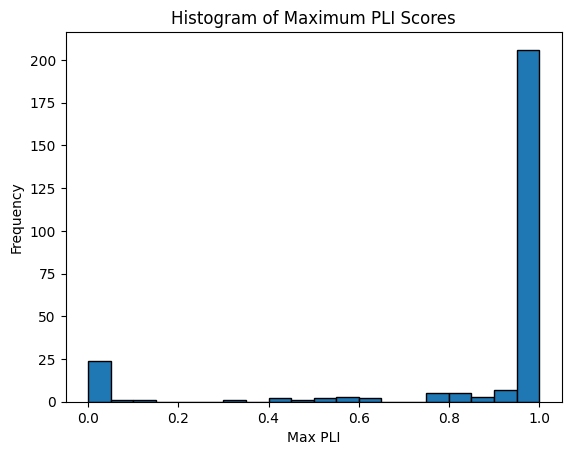

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.

    Args:
        ligand (BindingPocket): The ligand structure as a set of atomic coordinates.
        pocket (BindingPocket): The pocket structure as a set of atomic coordinates.
        cutoff_distance (float): The maximum distance (in Å) to consider an atom interacting.

    Returns:
        float: PLI score as a fraction of ligand atoms interacting with the pocket.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Generator to extract atomic coordinates from a molecular structure file.

    Args:
        file_path (str): Path to the molecular structure file (PDB or SDF).
        heavy_only (bool): If True, only include heavy atoms (atomic number > 1).

    Yields:
        np.ndarray: A NumPy array of atomic coordinates.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            yield np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            yield np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for all ligand poses and all pockets in a subfolder.

    Args:
        subdir_path (str): Path to the subfolder containing pocket and ligand files.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).

    Returns:
        float: Maximum PLI score among all poses and pockets in the subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket_thr05_Minimal" in file and file.endswith(".pdb")]
    ligand_files = [file for file in os.listdir(subdir_path) if file.endswith("_ligands.sdf")]

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}")
    if not ligand_files:
        print(f"No ligand files found in {subdir_path}")

    if not pocket_files or not ligand_files:
        return None

    max_pli = 0
    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = next(coordinates(pocket_file_path, heavy_only=False))
        pocket = BindingPocket(pocket_coords)

        for ligand_file in ligand_files:
            ligand_file_path = os.path.join(subdir_path, ligand_file)
            print(f"Loading ligand file: {ligand_file_path}")
            for pose_idx, lig_coords in enumerate(coordinates(ligand_file_path, heavy_only=True), start=1):
                ligand = BindingPocket(lig_coords)
                pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
                print(f"Pose {pose_idx}: PLI = {pli:.3f}")
                max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder.

    Args:
        main_folder (str): Path to the main folder containing subfolders.
        subfolder_list_file (str): Path to the file listing subfolder names.
        output_csv (str): Path to save the output CSV file.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).
    """

    print(f"Reading subfolder list from: {subfolder_list_file}")
    with open(subfolder_list_file, 'r') as f:
        subfolders = [line.strip() for line in f]

    results = []

    for subdir in subfolders:
        subdir_path = os.path.join(main_folder, subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/Docking_benchmarks/Kalasanty_comparison/posebusters_benchmark_set"
subfolder_list_file = "/content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt"
output_csv = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET_Kalasanty_max_pli_results.csv"

process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0)

Reading subfolder list from: /content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt
Processing subfolder: /content/gdrive/MyDrive/Docking_benchmarks/PUResNet_comparison/posebusters_benchmark_set/5SAK_ZRY
Loading pocket file: /content/gdrive/MyDrive/Docking_benchmarks/PUResNet_comparison/posebusters_benchmark_set/5SAK_ZRY/pocket_thr05_Minimal0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PUResNet_comparison/posebusters_benchmark_set/5SAK_ZRY/pocket_thr05_Minimal0.pdb
Loading ligand file: /content/gdrive/MyDrive/Docking_benchmarks/PUResNet_comparison/posebusters_benchmark_set/5SAK_ZRY/5SAK_ZRY_ligands.sdf
Reading coordinates from file: /content/gdrive/MyDrive/Docking_benchmarks/PUResNet_comparison/posebusters_benchmark_set/5SAK_ZRY/5SAK_ZRY_ligands.sdf
Pose 1: PLI = 1.000
Max PLI for subfolder /content/gdrive/MyDrive/Docking_benchmarks/PUResNet_comparison/posebusters_benchmark_set/5SAK_ZRY: 1.000
Processing subfolder: /content/gdrive/MyDri

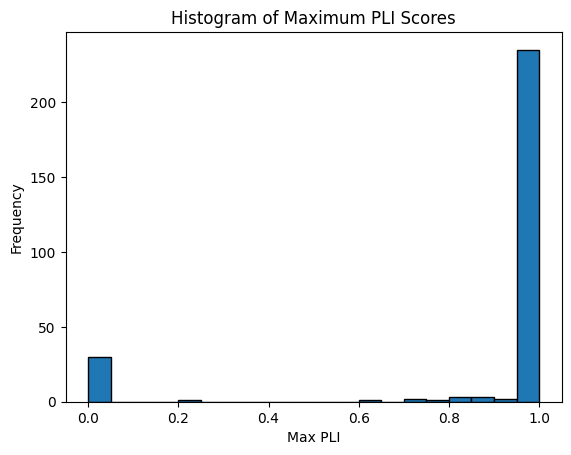

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.

    Args:
        ligand (BindingPocket): The ligand structure as a set of atomic coordinates.
        pocket (BindingPocket): The pocket structure as a set of atomic coordinates.
        cutoff_distance (float): The maximum distance (in Å) to consider an atom interacting.

    Returns:
        float: PLI score as a fraction of ligand atoms interacting with the pocket.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Generator to extract atomic coordinates from a molecular structure file.

    Args:
        file_path (str): Path to the molecular structure file (PDB or SDF).
        heavy_only (bool): If True, only include heavy atoms (atomic number > 1).

    Yields:
        np.ndarray: A NumPy array of atomic coordinates.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            yield np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            yield np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for all ligand poses and all pockets in a subfolder.

    Args:
        subdir_path (str): Path to the subfolder containing pocket and ligand files.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).

    Returns:
        float: Maximum PLI score among all poses and pockets in the subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket_thr05_Minimal" in file and file.endswith(".pdb")]
    ligand_files = [file for file in os.listdir(subdir_path) if file.endswith("_ligands.sdf")]

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}")
    if not ligand_files:
        print(f"No ligand files found in {subdir_path}")

    if not pocket_files or not ligand_files:
        return None

    max_pli = 0
    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = next(coordinates(pocket_file_path, heavy_only=False))
        pocket = BindingPocket(pocket_coords)

        for ligand_file in ligand_files:
            ligand_file_path = os.path.join(subdir_path, ligand_file)
            print(f"Loading ligand file: {ligand_file_path}")
            for pose_idx, lig_coords in enumerate(coordinates(ligand_file_path, heavy_only=True), start=1):
                ligand = BindingPocket(lig_coords)
                pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
                print(f"Pose {pose_idx}: PLI = {pli:.3f}")
                max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder.

    Args:
        main_folder (str): Path to the main folder containing subfolders.
        subfolder_list_file (str): Path to the file listing subfolder names.
        output_csv (str): Path to save the output CSV file.
        cutoff_distance (float): Distance threshold for interaction (default: 5.0 Å).
    """
    print(f"Reading subfolder list from: {subfolder_list_file}")
    with open(subfolder_list_file, 'r') as f:
        subfolders = [line.strip() for line in f]

    results = []

    for subdir in subfolders:
        subdir_path = os.path.join(main_folder, subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/Docking_benchmarks/PUResNet_comparison/posebusters_benchmark_set"
subfolder_list_file = "/content/gdrive/MyDrive/Docking_benchmarks/posebusters_pdb_ccd_ids.txt"
output_csv = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET_PUResNet_max_pli_results.csv"

process_all_subfolders(main_folder, subfolder_list_file, output_csv, cutoff_distance=5.0)


Reading PLI values from: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET_Kalasanty_max_pli_results.csv
File /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET_Kalasanty_max_pli_results.csv has less than 308 entries. Padding missing values with zeros.
Reading PLI values from: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET_PUResNet_max_pli_results.csv
File /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET_PUResNet_max_pli_results.csv has less than 308 entries. Padding missing values with zeros.
Reading PLI values from: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET32_max_pli_results.csv
File /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET32_max_pli_results.csv has less than 308 entries. Padding missing values with zeros.
Reading PLI values from: /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET33_max_pli_results.csv
File /content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET33_max_pli_results.csv has less than 308 entrie

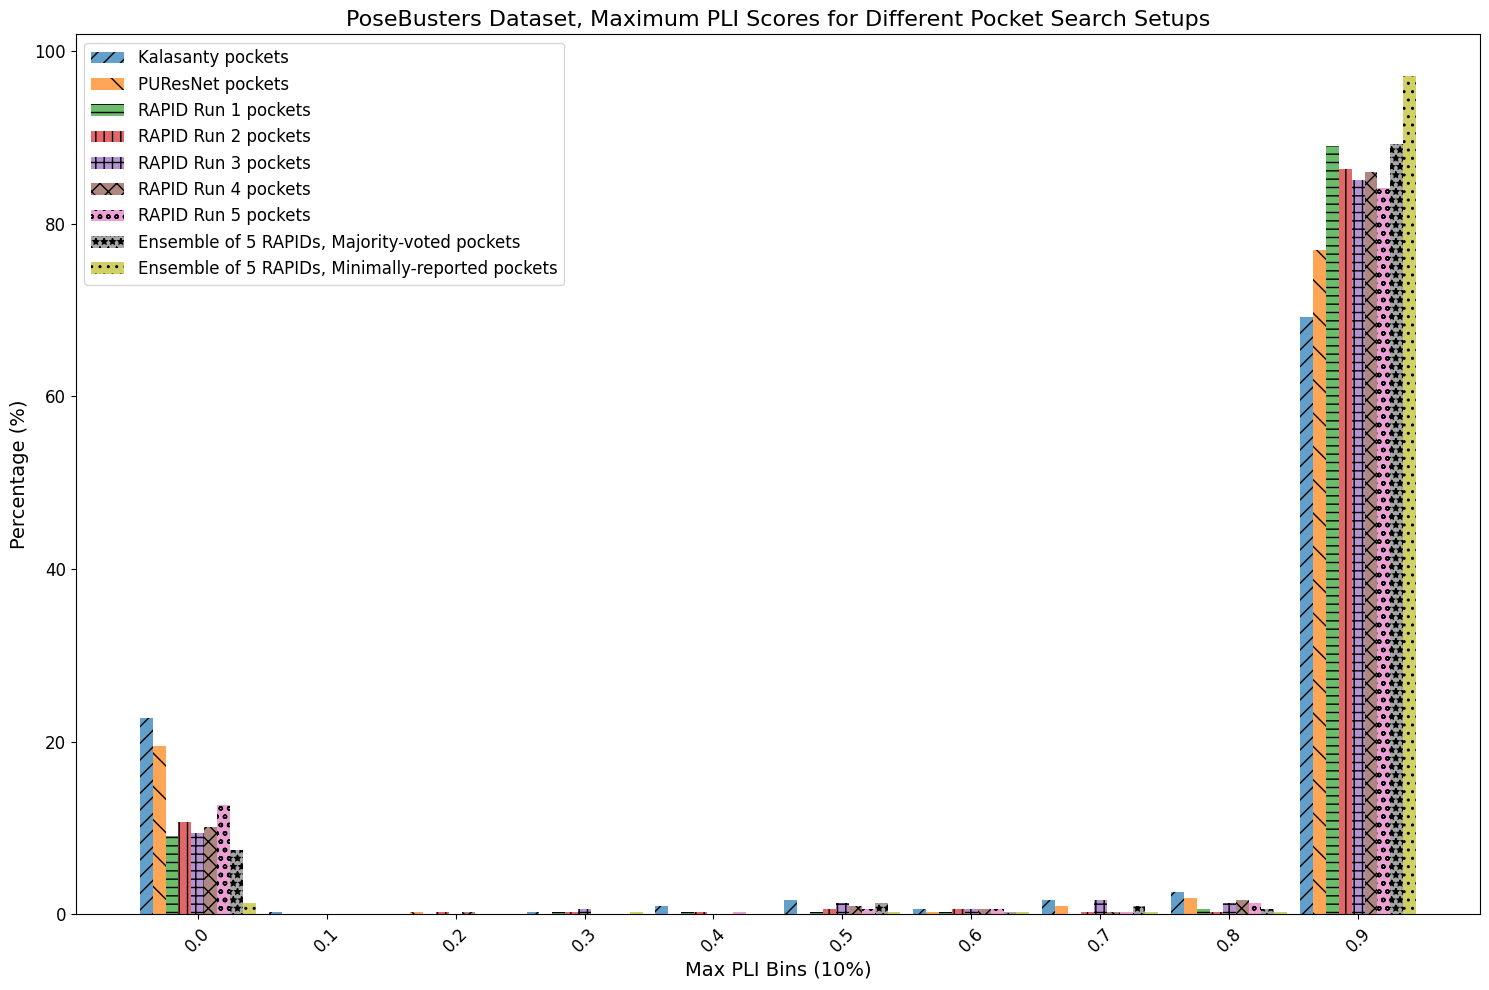

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def plot_combined_bar_chart(csv_files, output_chart):
    """
    Plot a combined bar chart of PLI values from multiple CSV files, with each dataset shown side-by-side.

    Args:
        csv_files (list of str): List of paths to CSV files containing PLI results.
        output_chart (str): Path to save the output bar chart plot.
    """
    pli_data = []
    labels = [
        "Kalasanty pockets",
        "PUResNet pockets",
        "RAPID Run 1 pockets",
        "RAPID Run 2 pockets",
        "RAPID Run 3 pockets",
        "RAPID Run 4 pockets",
        "RAPID Run 5 pockets",
        "Ensemble of 5 RAPIDs, Majority-voted pockets",
        "Ensemble of 5 RAPIDs, Minimally-reported pockets"
    ]

    total_count = 308

    for csv_file in csv_files:
        print(f"Reading PLI values from: {csv_file}")
        df = pd.read_csv(csv_file)
        if "Max PLI" not in df.columns:
            print(f"Warning: 'Max PLI' column not found in {csv_file}")
            pli_data.append([0] * total_count)
            continue

        pli_values = df["Max PLI"].dropna().tolist()

        if len(pli_values) < total_count:
            print(f"File {csv_file} has less than {total_count} entries. Padding missing values with zeros.")
            pli_values.extend([0] * (total_count - len(pli_values)))

        pli_data.append(pli_values)

    if not pli_data:
        print("No valid PLI data found. Exiting.")
        return

    num_bins = 10
    bins = np.linspace(0, 1, num_bins + 1)
    bar_width = 0.1
    x_positions = np.arange(num_bins)

    plt.figure(figsize=(15, 10))

    hatches = ["//", "\\", "--", "||", "++", "xx", "oo", "**", ".."]

    for i, data in enumerate(pli_data):
        hist, _ = np.histogram(data, bins=bins)
        percentages = (hist / total_count) * 100
        bar_positions = x_positions + i * bar_width
        plt.bar(bar_positions, percentages, width=bar_width, label=labels[i], alpha=0.7, hatch=hatches[i % len(hatches)])

    plt.xlabel("Max PLI Bins (10%)", fontsize=14)
    plt.ylabel("Percentage (%)", fontsize=14)
    plt.title("PoseBusters Dataset, Maximum PLI Scores for Different Pocket Search Setups", fontsize=16)
    plt.xticks(x_positions + bar_width * (len(pli_data) - 1) / 2, [f"{b:.1f}" for b in bins[:-1]], rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='upper left', fontsize=12)

    plt.tight_layout()
    plt.savefig(output_chart)
    print(f"Combined bar chart saved to: {output_chart}")
    plt.show()

csv_files = [
    "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET_Kalasanty_max_pli_results.csv",
    "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET_PUResNet_max_pli_results.csv",
    "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET32_max_pli_results.csv",
    "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET33_max_pli_results.csv",
    "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET35_max_pli_results.csv",
    "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET36_max_pli_results.csv",
    "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET41_max_pli_results.csv",
    "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET_Ensemble_Majority_max_pli_results.csv",
    "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/SET_Ensemble_MINORITY_max_pli_results.csv",
]

output_chart = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/combined_pli_bar_chart.png"
plot_combined_bar_chart(csv_files, output_chart)
